# Q-Learning

Episode 50/2000, Total Reward: 27.464107494743022
Episode 100/2000, Total Reward: -7.621635271632205
Episode 150/2000, Total Reward: 19.928954051501442
Episode 200/2000, Total Reward: -1.3538826600300666
Episode 250/2000, Total Reward: -14.618023951294504
Episode 300/2000, Total Reward: 40.25254033104653
Episode 350/2000, Total Reward: 21.670723254195337
Episode 400/2000, Total Reward: 23.445669649173215
Episode 450/2000, Total Reward: 31.200729629345318
Episode 500/2000, Total Reward: 12.95585931010099
Episode 550/2000, Total Reward: 41.54253347441003
Episode 600/2000, Total Reward: 15.542593554422766
Episode 650/2000, Total Reward: 23.491401336821227
Episode 700/2000, Total Reward: 42.735695009851305
Episode 750/2000, Total Reward: 23.49140133682122
Episode 800/2000, Total Reward: 44.28991649170088
Episode 850/2000, Total Reward: 43.80486483084135
Episode 900/2000, Total Reward: 43.804864830841325
Episode 950/2000, Total Reward: 43.804864830841325
Episode 1000/2000, Total Reward: 43.

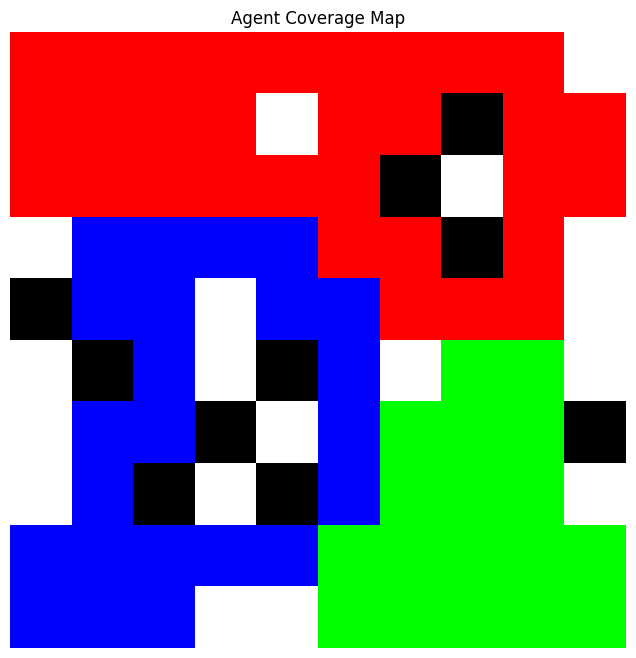

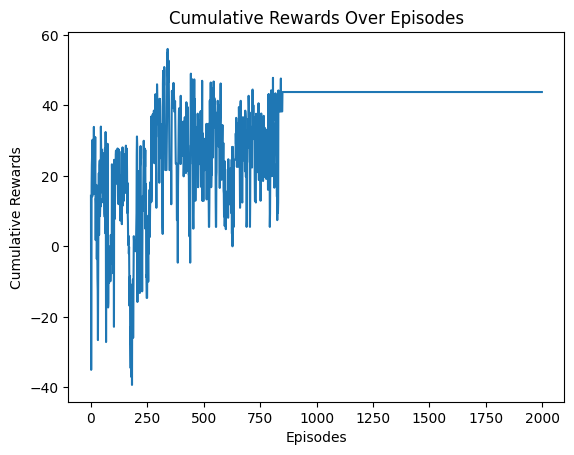

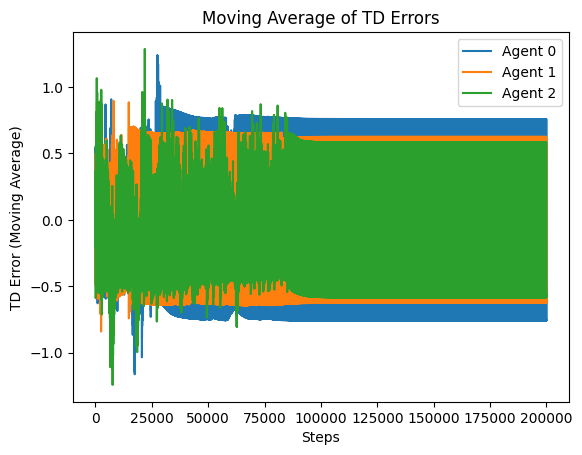

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MultiAgentGridEnvironment:
    def __init__(self, grid_size=10, num_agents=3, num_obstacles=10, random_seed=42):
        self.grid_size = grid_size
        self.num_agents = num_agents
        self.num_obstacles = num_obstacles
        self.random_seed = random_seed
        self.agent_positions = []
        self.obstacles = []
        self.grid = None
        self.agent_coverage = None
        self.done = False
        self.steps = 0
        self.start_positions = [(0, 0), (9, 0), (9, 9)]  # Fixed starting positions
        self.reset()

    def _generate_obstacles(self):
        np.random.seed(self.random_seed)
        obstacles = set()
        while len(obstacles) < self.num_obstacles:
            pos = (np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size))
            if pos not in self.agent_positions and pos not in self.start_positions:
                obstacles.add(pos)
        return list(obstacles)

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.agent_coverage = np.full((self.grid_size, self.grid_size), -1, dtype=int)
        self.agent_positions = self.start_positions.copy()
        self.obstacles = self._generate_obstacles()
        for obs in self.obstacles:
            self.grid[obs] = -1
        for i, pos in enumerate(self.agent_positions):
            self.grid[pos] = 1
            self.agent_coverage[pos] = i
        self.done = False
        self.steps = 0
        return self.grid, self.agent_positions

    def step(self, actions):
        rewards = np.zeros(self.num_agents)
        next_positions = []
        moves = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

        for i, action in enumerate(actions):
            current_pos = self.agent_positions[i]
            dx, dy = moves[action]
            next_pos = (current_pos[0] + dx, current_pos[1] + dy)

            # Check boundaries
            if not (0 <= next_pos[0] < self.grid_size and 0 <= next_pos[1] < self.grid_size):
                rewards[i] = -1
                next_positions.append(current_pos)
                continue

            # Check obstacles
            if self.grid[next_pos] == -1:
                rewards[i] = -1
                next_positions.append(current_pos)
                continue

            # Check if already visited
            if self.grid[next_pos] == 1:
                rewards[i] = -0.5  # Smaller penalty for revisiting
            else:
                # Distance-based reward
                distance_to_start = np.linalg.norm(np.array(next_pos) - np.array(self.start_positions[i]))
                rewards[i] = 10 / (distance_to_start + 1)

            next_positions.append(next_pos)
            self.grid[next_pos] = 1
            self.agent_coverage[next_pos] = i

        self.agent_positions = next_positions
        self.steps += 1
        if np.all(self.grid[self.grid != -1] == 1):
            self.done = True
            rewards += 50  # Large reward for completing the task
        return self.grid, rewards, self.done

    def render_agent_coverage(self):
        display_grid = np.zeros((self.grid_size, self.grid_size, 3), dtype=float)
        agent_colors = [[1, 0, 0], [0, 0, 1], [0, 1, 0]]

        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.agent_coverage[x, y] != -1:
                    display_grid[x, y] = agent_colors[self.agent_coverage[x, y] % len(agent_colors)]
                elif self.grid[x, y] == -1:
                    display_grid[x, y] = [0, 0, 0]
                else:
                    display_grid[x, y] = [1, 1, 1]

        plt.figure(figsize=(8, 8))
        plt.imshow(display_grid, origin="upper")
        plt.title("Agent Coverage Map")
        plt.axis('off')
        plt.show()


class MultiAgentQLearning:
    def __init__(self, num_agents, grid_size, alpha=0.05, gamma=0.9, epsilon=0.99, epsilon_decay=0.5):
        self.num_agents = num_agents
        self.grid_size = grid_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_tables = [np.zeros((grid_size, grid_size, 4)) for _ in range(num_agents)]
        self.td_errors = [[] for _ in range(num_agents)]  # Track TD errors

    def select_action(self, agent_index, state, episode):
        x, y = state
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        return np.argmax(self.q_tables[agent_index][x, y])

    def update_q_table(self, agent_index, state, action, reward, next_state):
        x, y = state
        nx, ny = next_state
        old_value = self.q_tables[agent_index][x, y, action]
        next_max = np.max(self.q_tables[agent_index][nx, ny])
        td_error = reward + self.gamma * next_max - old_value
        self.td_errors[agent_index].append(td_error)
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_tables[agent_index][x, y, action] = new_value


def train(grid_size=10, num_agents=3, num_obstacles=10, episodes=2000):
    env = MultiAgentGridEnvironment(grid_size, num_agents, num_obstacles)
    agent = MultiAgentQLearning(num_agents, grid_size)
    cumulative_rewards = []
    agent.start_positions = env.start_positions

    for episode in range(episodes):
        grid, agent_positions = env.reset()
        state = agent_positions
        total_reward = 0
        for step in range(100):
            actions = [agent.select_action(i, state[i], episode) for i in range(num_agents)]
            next_grid, rewards, done = env.step(actions)
            next_state = env.agent_positions
            for i in range(num_agents):
                agent.update_q_table(i, state[i], actions[i], rewards[i], next_state[i])
            state = next_state
            total_reward += sum(rewards)
            if done:
                break
        cumulative_rewards.append(total_reward)
        agent.epsilon *= agent.epsilon_decay

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    env.render_agent_coverage()

    # Plot cumulative rewards
    plt.plot(cumulative_rewards)
    plt.title("Cumulative Rewards Over Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Rewards")
    plt.show()

    # Plot moving average TD errors
    window_size = 50
    for i in range(num_agents):
        td_errors = np.array(agent.td_errors[i])
        moving_avg = np.convolve(td_errors, np.ones(window_size) / window_size, mode='valid')
        plt.plot(moving_avg, label=f'Agent {i}')
    plt.title("Moving Average of TD Errors")
    plt.xlabel("Steps")
    plt.ylabel("TD Error (Moving Average)")
    plt.legend()
    plt.show()


train()
